In [2]:
import tensorflow as tf 
# https://sci-hub.se/10.1002/sim.1203
# https://journals.sagepub.com/doi/pdf/10.1177/1536867x0900900206

# Centralized setting 

$$
H(t \mid z) = H_0(t) \exp(\beta^\top z)
$$
$$
\ln H(t \mid z) = s(x \mid \gamma, k) + \beta^\top z
$$
$$
x = \ln t
$$
$$
k_{\min} < k_1 < \dots < k_m < k_{\max}
$$
$$
s(x \mid \gamma) = \gamma_0 + \gamma_1x + \dots + \gamma_{m+1} v_m(x)
$$
$$
v_j(x) = (x- k_j)_+^3 - \lambda_j(x - k_{\min})_+^3 - (1 - \lambda_j)(x - k_{\max})^3_+
$$
$$
\lambda_j = \frac{k_{\max} - k_j}{k_{\max} - k_{\min}}
$$
$$
\frac{ds}{dx} = \gamma_1 + \dots +  \gamma_{m+1} \frac{dv_m(x)}{dx}
$$
$$
\eta = s(x) + \beta^\top z 
$$

TODO: Let the linear estimator be a neural network?

In [3]:
import numpy as np 
from sksurv.datasets import load_aids, load_breast_cancer, load_veterans_lung_cancer
from sklearn.model_selection import train_test_split

# Load dataset 
X, y = load_breast_cancer() # load_veterans_lung_cancer() # load_aids() #load_breast_cancer()

# Unpack 
event, duration = zip(*y)
e = np.array(event)
t = np.array(duration) 
print(min(t), max(t), np.log(min(t)), np.log(max(t)))

# Drop columns that are not numerical 
X = X[X.columns[X.dtypes != "category"]]
# Drop some arbitrary columns to reduce dimensionality
X = X.iloc[:, :10]

# Train-test splitting 
train_idx, test_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.25, random_state=42, stratify=e.astype(int)
)
X_train, X_test = X.iloc[train_idx].to_numpy(), X.iloc[test_idx].to_numpy()
y_train, y_test = y[train_idx], y[test_idx]
e_train, e_test = e[train_idx], e[test_idx]
t_train, t_test = t[train_idx], t[test_idx]

X_train.shape, X_test.shape 

125.0 9108.0 4.8283137373023015 9.11690842718363


((148, 10), (50, 10))

In [4]:
X.head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at
0,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,9.623518,9.814798,10.016732,7.847383
1,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,10.604577,10.704329,10.161838,8.744875
2,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,9.384927,10.161654,10.032721,8.125487
3,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,8.400839,8.670721,10.727427,8.650810
4,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,7.741092,8.642018,9.556686,8.478862


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
x_train = np.log(t_train)
x_test = np.log(t_test)

# k_min = min(knots)
# k_max = max(knots)
# internal knots: k_min < knots < k_max
knots = np.percentile(x_train, np.linspace(0, 1, 5) * 100)
knots

array([5.59471138, 7.86064127, 8.38569183, 8.61978978, 9.11690843])

In [7]:
def spline_basis(x, k_j):
    k_1, k_K = knots[0], knots[-1]
    phi = (k_K - k_j) / (k_K - k_1)
    pos = lambda q: np.maximum(0, q)
    return pos(x - k_j) ** 3 - phi * pos(x - k_1) ** 3 - (1 - phi) * pos(x - k_K) ** 3


def gram_schmidt_ortho(A):
    # Ensure the matrix is a NumPy array of floats
    A = np.array(A, dtype=np.float64)  
    m, n = A.shape

    # Initialize the orthogonalized matrix
    Q = np.zeros_like(A)
    for i in range(n):
        v = A[:, i]
        for j in range(i):
            # Subtract projections onto previous vectors
            v -= np.dot(Q[:, j], A[:, i]) * Q[:, j]  
        # Normalize the vector
        Q[:, i] = v / np.linalg.norm(v)  
    return Q 


S_basis = [] 
for k_j in knots[1:-1]:
    S_basis.append(spline_basis(x_train, k_j))
S_basis = np.array(S_basis)

# Orthogonalize the derived splines variables
#S_basis = gram_schmidt_ortho(S_basis)

# Spline design matrix 
D_train = np.transpose(np.vstack([np.ones_like(x_train), x_train, S_basis]))
D_train.shape 

(148, 5)

In [8]:
k_1, k_K = knots[0], knots[-1]
pos = lambda q: np.maximum(0, q)
#c = pos(x - k_j) ** 3 - phi * pos(x - k_1) ** 3 - (1 - phi) * pos(x - k_K) ** 3

c = 8.38569183
for k in knots[1:-1]:
    print(k, pos(c - k) ** 3, pos(c - k_1) ** 3, pos(c - k_K))

7.860641274046226 0.1447449324799563 21.74054281871405 0.0
8.38569182729518 1.9788629258266158e-26 21.74054281871405 0.0
8.61978978339249 0.0 21.74054281871405 0.0


In [9]:
def spline_basis_derivative(x, k_j):
    k_1, k_K = knots[0], knots[-1]
    phi = (k_K - k_j) / (k_K - k_1)
    pos = lambda q: np.maximum(0, q)
    return 3 * pos(x - k_j) ** 2 - 3 * phi * pos(x - k_1) ** 2 - 3 * (1 - phi) * pos(x - k_K) ** 2

dS_basis = [] 
for k_j in knots[1:-1]:
    dS_basis.append(spline_basis_derivative(x_train, k_j))
    
# Derivative spline design matrix 
dD_train = np.transpose(np.vstack([np.zeros_like(x_train), np.ones_like(x_train), dS_basis]))
dD_train.shape 

(148, 5)

In [10]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
cox = CoxPHSurvivalAnalysis()
cox.fit(X, y)
beta_np = cox.coef_[None, :].astype(np.float64) 

np.random.seed(42)
#beta_np = np.random.uniform(size=(1, int(X.shape[1]))).astype(np.float64)
gamma_np = np.random.uniform(size=(1, int(D_train.shape[1]))).astype(np.float64)

beta_np.shape, gamma_np.shape 

((1, 10), (1, 5))

In [11]:
beta = tf.Variable(beta_np, dtype=tf.float32)
gamma = tf.Variable(gamma_np, dtype=tf.float32)

X_train_tf = tf.cast(X_train, dtype=tf.float32)
D_train_tf = tf.cast(D_train, dtype=tf.float32)
dD_train_tf = tf.cast(dD_train, dtype=tf.float32)

e_train_tf = tf.cast(e_train[:, None], dtype=tf.float32)
t_train_tf = tf.cast(t_train[:, None], dtype=tf.float32)


# NOTE: Recall z > 0 for log(z) to be defined. A common problem is dsdx < 0
def loss():    
    eta = D_train_tf @ tf.transpose(gamma) + X_train_tf @ tf.transpose(beta)
    f1 = 1 / t_train_tf * dD_train_tf @ tf.transpose(gamma) * tf.math.exp(eta - tf.math.exp(eta))
    f2 = 1 / (1 + tf.math.exp(eta))
    return -1 * tf.reduce_sum(tf.math.log(1 + e_train_tf * f1 + (1 - e_train_tf) * f2))
    #return e_train_tf * (tf.math.log(dD_train_tf @ tf.transpose(gamma)) + eta) - tf.math.exp(eta)
    

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for epoch in tf.range(50):

    with tf.GradientTape() as tape:
        loss_value = loss()
    
    # Compute gradients
    gradients = tape.gradient(loss_value, [gamma, beta])
    # Apply gradients to update gamma and beta
    optimizer.apply_gradients(zip(gradients, [gamma, beta]))
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy().mean()}")


from sksurv.metrics import concordance_index_censored
r_train = (X_train @ np.transpose(beta.numpy())).squeeze()
r_test = (X_test @ np.transpose(beta.numpy())).squeeze()
print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))

Epoch 0, Loss: -53.06026077270508
Epoch 5, Loss: -75.66867065429688
Epoch 10, Loss: -75.9951171875
Epoch 15, Loss: -76.09046936035156
Epoch 20, Loss: -76.13279724121094
Epoch 25, Loss: -76.15642547607422
Epoch 30, Loss: -76.17150115966797
Epoch 35, Loss: -76.18196868896484
Epoch 40, Loss: -76.18968963623047
Epoch 45, Loss: -76.19562530517578
(0.6936977637226113, 3071, 1356, 0, 0)
(0.65748031496063, 334, 174, 0, 0)


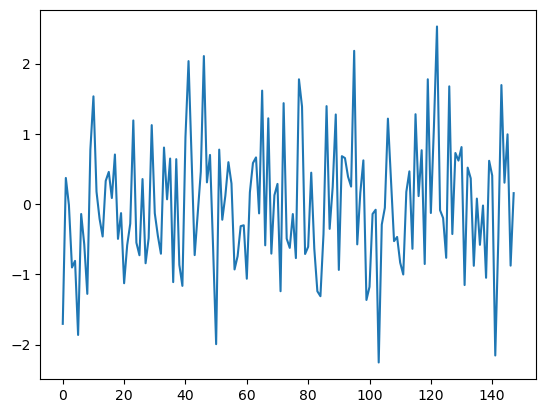

In [12]:
import matplotlib.pyplot as plt 
#eta = D_train @ np.transpose(gamma.numpy()) + X_train @ np.transpose(beta.numpy())
#plt.plot(np.exp(-np.exp(eta)).squeeze())
plt.plot(X_train @ np.transpose(beta.numpy()))

# De-centralized setting 

In [13]:
class Client:
    
    def __init__(self, beta, gamma):
        self.beta = beta
        self.gamma = gamma 

    def get_params(self):
        return self.beta, self.gamma 

    def set_params(self, beta, gamma):
        self.beta = beta 
        self.gamma = gamma 

    def fit(self, X, D, dD, t, e):
        
        def _loss():    
            eta = D @ tf.transpose(gamma) + X @ tf.transpose(beta)
            f1 = 1 / t * dD @ tf.transpose(gamma) * tf.math.exp(eta - tf.math.exp(eta))
            f2 = 1 / (1 + tf.math.exp(eta))        
            return -1 * tf.reduce_sum(tf.math.log(1 + e * f1 + (1 - e) * f2))
            
        beta = tf.Variable(self.beta, dtype=tf.float32, name="beta")
        gamma = tf.Variable(self.gamma, dtype=tf.float32, name="gamma")

        X = tf.cast(X, dtype=tf.float32)
        D = tf.cast(D, dtype=tf.float32)
        dD = tf.cast(dD, dtype=tf.float32)

        t = tf.cast(t, dtype=tf.float32)
        e = tf.cast(e, dtype=tf.float32)

        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        for epoch in tf.range(5):

            with tf.GradientTape() as tape:
                loss_value = _loss()

            gradients = tape.gradient(loss_value, [gamma, beta])
            optimizer.apply_gradients(zip(gradients, [gamma, beta]))
    
        self.beta = beta.numpy()
        self.gamma = gamma.numpy()

        self.loss = float(loss_value.numpy().mean())

In [14]:
n_participants = 4

clients = [Client(beta_np, gamma_np) for _ in range(n_participants)]

idx = np.array_split(np.arange(X_train.shape[0]), n_participants)

for epoch in range(20):

    losses, betas, gammas = [], [], []
    for i, cli in enumerate(clients):
        cli.fit(X_train[idx[i]], D_train[idx[i]], dD_train[idx[i]], t_train[[idx[i]], None], e_train[[idx[i]], None])

        beta_i, gamma_i = cli.get_params()
        betas.append(beta_i)
        gammas.append(gamma_i)
        
        losses.append(cli.loss)

    beta_avg = sum(betas) / len(betas)
    gamma_avg = sum(gammas) / len(gammas)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {np.mean(losses)}")
        
    for i, cli in enumerate(clients):
        cli.set_params(beta_avg, gamma_avg)

Epoch 0, Loss: -17.55409049987793
Epoch 5, Loss: -18.851585626602173
Epoch 10, Loss: -18.99194049835205
Epoch 15, Loss: -19.02248239517212


In [15]:
beta_avg, gamma_avg = 0, 0
for i, cli in enumerate(clients):
    beta_i, gamma_i = cli.get_params()
    
    beta_avg += beta_i
    gamma_avg += gamma_i

beta_avg /= n_participants
gamma_avg /= n_participants

# Comparison

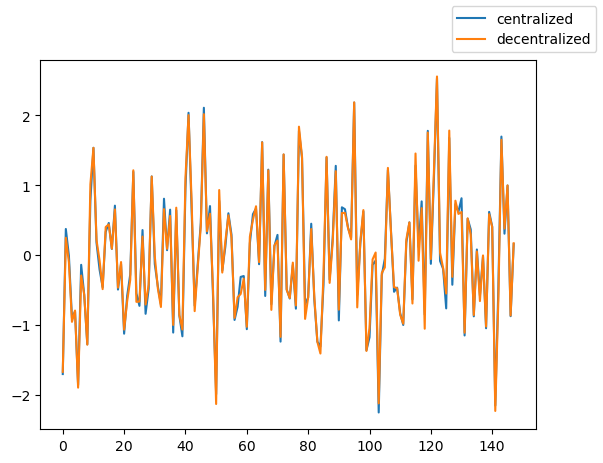

In [16]:
fig, axis = plt.subplots(1, 1)
axis.plot((X_train @ np.transpose(beta.numpy())).squeeze(), label="centralized")
axis.plot((X_train @ np.transpose(beta_avg)).squeeze(), label="decentralized")
fig.legend()

In [17]:
(X_train @ np.transpose(beta.numpy())).squeeze()[:4]

array([-1.70374125,  0.37211367, -0.01184338, -0.90181629])

In [18]:
(X_train @ np.transpose(beta_avg)).squeeze()[:4]

array([-1.67202066,  0.24643599, -0.10421245, -0.95631312])

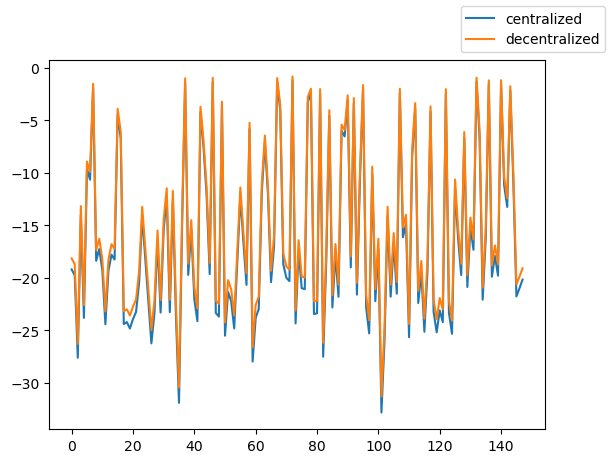

In [19]:
# breast cancer 
scale = 1.18 
shift = 0 

# load_aids
#scale = 1.4
#shift = 1

# load_veterans_lung_cancer
#scale = 1
#shift = 0

fig, axis = plt.subplots(1, 1)
axis.plot((D_train @ np.transpose(gamma.numpy())).squeeze(), label="centralized")
axis.plot(scale * (D_train @ np.transpose(gamma_avg)).squeeze() - shift, label="decentralized")
fig.legend()

In [20]:
r_train = (X_train @ np.transpose(beta.numpy())).squeeze()
r_test = (X_test @ np.transpose(beta.numpy())).squeeze()

print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))

(0.6936977637226113, 3071, 1356, 0, 0)
(0.65748031496063, 334, 174, 0, 0)


In [21]:
r_train = (X_train @ np.transpose(beta_avg)).squeeze()
r_test = (X_test @ np.transpose(beta_avg)).squeeze()

print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))

(0.69414953693246, 3073, 1354, 0, 0)
(0.6614173228346457, 336, 172, 0, 0)


In [22]:
def survival_curve(X, beta, t, gamma):

    S = [] 
    for k_j in knots[1:-1]:
        S.append(spline_basis(np.log(t), k_j))
    
    # Spline design matrix 
    D = np.array([1, np.log(t)] + S)[None, :]

    eta = (D @ gamma.T).squeeze() + (X @ beta.T).squeeze()
    return np.exp(-np.exp(eta))


# NOTE: Survival should be in [0, 1], decreasing over time 
survival_curve(X_train[0], beta.numpy(), 4, gamma.numpy())

0.8521044431126709

In [23]:
#times = np.linspace(min(x_train), max(x_train), 20)
times = np.linspace(1, 100, 20)
times

array([  1.        ,   6.21052632,  11.42105263,  16.63157895,
        21.84210526,  27.05263158,  32.26315789,  37.47368421,
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ])

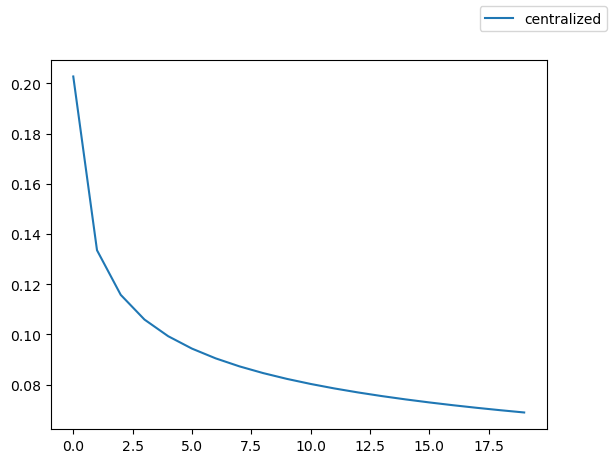

In [24]:
survival = np.array([survival_curve(X_train[0], beta.numpy(), ti, gamma.numpy()) for ti in times])

# NOTE: Survival should be in [0, 1], decreasing over time 
fig, axis = plt.subplots(1, 1)
axis.plot(1 - survival, label="centralized")
#axis.plot((D_train @ np.transpose(gamma_avg)).squeeze(), label="decentralized")
fig.legend()

In [31]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
cox = CoxPHSurvivalAnalysis()
cox.fit(X.to_numpy(), y)
print(concordance_index_censored(e_train, t_train, cox.predict(X_train)))
print(concordance_index_censored(e_test, t_test, cox.predict(X_test)))

(0.677659814772984, 3000, 1427, 0, 0)
(0.6259842519685039, 318, 190, 0, 0)


In [46]:
cox.predict_survival_function(X_train, return_array=True).mean(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])